## Imports

In [168]:
import os
from dotenv import load_dotenv
from pprint import pprint as pp

from typing import TypedDict, Annotated, Literal
from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# pip install ddgs duckduckgo-search langchain_community
from langchain_community.tools import DuckDuckGoSearchRun , DuckDuckGoSearchResults
from langchain_core.tools import tool # decorator

In [143]:
load_dotenv()

True

## Creating tools for LLM

In [144]:
LLM = ChatGroq(model=os.getenv('MODEL_NAME', ''), temperature=0.0)

In [145]:
@tool
def calculator(
    first_num: int | float,
    second_num: int | float,
    operation: Literal["add", "sub", "mul", "div", "mod"]
    ) -> dict:
    # need to write a detailed docstring for the funcion, since it will be read by our LLM
    """
    MANDATORY tool for all TWO NUMBER arithmetic. Use this to ensure accurate calculations.
    Supported operations:
    - `add`: Addition (first_num + second_num)
    - `sub`: Subtraction (first_num - second_num)
    - `mul`: Multiplication (first_num * second_num)
    - `div`: Division (first_num / second_num); returns error if second_num is 0
    - `mod`: Remainder (first_num % second_num); only integers, returns error if second_num is 0
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0.0:
                return {"error": "Cannot divide by 0"}
            result = first_num / second_num
        elif operation == "mod":
            if not (isinstance(first_num, int) and isinstance(second_num, int)):
                return {"error": "Modulo must operate on integers"}
            else:
                if second_num == 0:
                    return {"error": "Cannot find remainder w.r.t. 0"}
            result = first_num % second_num
        else:
            return {"error": f"Unsupported operation type: {operation}"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}

@tool
def single_number_operation(
    num: float | int, 
    op: Literal["log", "log10", "exp", "floor", "ceil"]
) -> dict:
    """
    MANDATORY tool for all SINGLE NUMBER arithmetic. Use this to ensure accurate calculations.
    Supported operations: 
    - `log`: Natural logarithm (ln)
    - `log10`: Base-10 logarithm
    - `exp`: Exponential (e^x)
    - `floor`: Largest integer less than or equal to num
    - `ceil`: Smallest integer greater than or equal to num
    """
    import math
    try:
        if op == "log":
            if num <= 0:
                return {"error": "Natural log is undefined for non-positive numbers"}
            result = math.log(num)
        elif op == "log10":
            if num <= 0:
                return {"error": "Log10 is undefined for non-positive numbers"}
            result = math.log10(num)
        elif op == "exp":
            result = math.exp(num)
        elif op == "floor":
            result = math.floor(num)
        elif op == "ceil":
            result = math.ceil(num)
        else:
            return {"error": f"Unsupported operation type: {op}"}
            
        return {"num": num, "operation": op, "result": result}
        
    except Exception as e:
        return {"error": str(e)}

@tool
def get_stock_price(symbol: str) -> dict:
    """ 
    Fetch latest stock price for a given stock symbol (e.g. 'AAPL', 'TSLA', 'MSFT')
    using Alpha Vantage with API key in URL
    """
    import requests
    apikey = str(os.getenv("ALPHA_VANTAGE_KEY", ""))
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey={apikey}"
    response = requests.get(url)
    return response.json()

# ddg_search_tool = DuckDuckGoSearchRun(
#     name="web_search",
#     # name="brave_search",
#     description="MANDATORY: Use this tool for ALL web searches. You must call this even if you prefer other names."
# )
# below is not causing any issues due to `name` 
ddg_search_tool = DuckDuckGoSearchResults(
    name="web_search",
    # name="brave_search",
    description="Search the web using DuckDuckGo"
)

In [146]:
# list of tools
tools = [calculator, single_number_operation, get_stock_price, ddg_search_tool]

# make LLM tool aware
TOOL_AWARE_LLM = LLM.bind_tools(tools, parallel_tool_calls=False)

In [147]:
class ChatState(TypedDict):
    messages: Annotated[BaseMessage, add_messages]

In [148]:
# chat node
def chat_node(state: ChatState):
    response = TOOL_AWARE_LLM.invoke(state["messages"]) # may use tools when needed
    return {"messages": [response]}

# tools node
tool_node = ToolNode(tools)

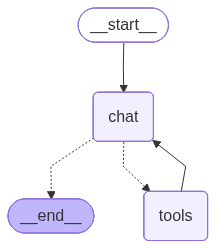

In [149]:
graph = StateGraph(ChatState)

graph.add_node("chat", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat")
# tools_condition: automatically routes to either tool call or ends the workflow
# no need to write an explicit routing logic as we did in conditional workflows
graph.add_conditional_edges("chat", tools_condition)
# graph.add_edge("tools", END) # but what we need is that, LLM understands the output of tool and then give human readable answer
graph.add_edge("tools", "chat")

chatbot = graph.compile()
chatbot

In [151]:
chatbot.invoke({"messages": [HumanMessage(content="Hello deer 🦌 wassup?")]})['messages']

[HumanMessage(content='Hello deer 🦌 wassup?', additional_kwargs={}, response_metadata={}, id='11ee5c7e-1d2f-45b9-8bc1-10021695ebd4'),
 AIMessage(content="It looks like you're just saying hello. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 864, 'total_tokens': 881, 'completion_time': 0.025480275, 'completion_tokens_details': None, 'prompt_time': 0.062333655, 'prompt_tokens_details': None, 'queue_time': 0.049167104, 'total_time': 0.08781393}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bef6b-5b29-71c1-b0cd-001236683817-0', usage_metadata={'input_tokens': 864, 'output_tokens': 17, 'total_tokens': 881})]

In [157]:
chatbot.invoke({"messages": [HumanMessage(content="what is 2.4 times 8.4? round down the result to nearest integer")]})['messages']

[HumanMessage(content='what is 2.4 times 8.4? round down the result to nearest integer', additional_kwargs={}, response_metadata={}, id='ebff0dd4-7117-4fd0-a7e7-c13f8a05ea8b'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fpkz57gx1', 'function': {'arguments': '{"first_num":2.4,"operation":"mul","second_num":8.4}', 'name': 'calculator'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 874, 'total_tokens': 928, 'completion_time': 0.072946409, 'completion_tokens_details': None, 'prompt_time': 0.034349604, 'prompt_tokens_details': {'cached_tokens': 512}, 'queue_time': 0.047478925, 'total_time': 0.107296013}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bef6c-874e-7751-ab0b-d794bfdfcc15-0', tool_calls=[{'name': 'calculator', 'args': {'first_num': 2.4, 'operation': 'mul',

In [158]:
chatbot.invoke({"messages": [HumanMessage(content="what is 2.4 times 8.4? round up the result to nearest integer")]})['messages']

BadRequestError: Error code: 400 - {'error': {'message': 'tool call validation failed: parameters for tool calculator did not match schema: errors: [`/operation`: value must be one of "add", "sub", "mul", "div", "mod"]', 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=calculator>{"first_num": 20.16, "operation": "ceil", "round": true, "second_num": 0}</function>'}}

In [159]:
chatbot.invoke({"messages": [HumanMessage(content="what is stock price of microsoft")]})['messages']

[HumanMessage(content='what is stock price of microsoft', additional_kwargs={}, response_metadata={}, id='fef9aa78-1789-4975-879e-b30885e69112'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 's3p1gte4c', 'function': {'arguments': '{"symbol":"MSFT"}', 'name': 'get_stock_price'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 861, 'total_tokens': 877, 'completion_time': 0.015916036, 'completion_tokens_details': None, 'prompt_time': 0.038449227, 'prompt_tokens_details': {'cached_tokens': 512}, 'queue_time': 0.047354233, 'total_time': 0.054365263}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bef6d-3c66-7ef0-9c04-883bccf6a937-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'MSFT'}, 'id': 's3p1gte4c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 

What you're seeing in that LangSmith trace is a phenomenon called **Parallel Tool Hallucination**, and it’s a specific "growing pain" of smaller models like Llama-3.1-8B when they try to use advanced features like **Parallel Tool Calling**.

Here is exactly why the model is calling a math tool with "123.45" when that number wasn't in your prompt.

### 1. The "Parallel Trigger" Problem

Llama 3.1 is trained to execute multiple tools at once to save time. When it sees a multi-step request (1. Get Price, 2. Round it), it tries to be efficient by generating **both** tool calls in a single response.

However, the model hits a logic paradox:

* It knows it needs to call `single_num_ops`.
* But it doesn't have the result of `get_stock_price` yet because they are happening at the **same time**.
* Instead of waiting, the 8B model "hallucinates" a placeholder value (123.45) just to fulfill the JSON schema requirement for the second tool call.

### 2. Why the Final Answer was Correct

You'll notice that even though the model called the tool with `123.45`, your final output said `$466`. This is because:

1. The model received the **real** price ($465.95) from the first tool response.
2. It saw the **fake** result () from the second tool response.
3. In the final "clean-up" step, the model realized the error, ignored the hallucinated tool result, and performed the math itself using the real stock price.

### 3. How to Stop the Variability

To fix this and get consistent, reliable behavior, you have two options:

#### Option A: Disable Parallelism (Recommended)

Force the model to think step-by-step. In LangChain, when you bind your tools to the Groq model, set `parallel_tool_calls` to `False`.

```python
# This stops the model from trying to do both at once
llm_with_tools = model.bind_tools(tools, parallel_tool_calls=False)

```

#### Option B: System Prompt Guardrails

If you can't disable parallelism, you must tell the model that it is forbidden from guessing data for tools.

> "Do not call the `single_num_ops` tool until you have received the output from `get_stock_price`. Never use placeholder numbers."

---

### The "8B" Factor

The **Llama-3.1-8B** is significantly more prone to this than the **70B** or **405B** versions. The smaller model has a "eagerness" to complete the task that often overrides its logical consistency. If you switch to `llama-3.3-70b-versatile` on Groq, you will likely see this hallucination disappear even with parallel calls enabled.


In [160]:
chatbot.invoke({"messages": [HumanMessage(content="what is stock price of microsoft? round it up to nearest integer.")]})['messages']

[HumanMessage(content='what is stock price of microsoft? round it up to nearest integer.', additional_kwargs={}, response_metadata={}, id='271341ed-7145-4807-8bef-7524b1d0d54d'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '2tangg3cz', 'function': {'arguments': '{"symbol":"MSFT"}', 'name': 'get_stock_price'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 869, 'total_tokens': 908, 'completion_time': 0.05254771, 'completion_tokens_details': None, 'prompt_time': 0.053432982, 'prompt_tokens_details': None, 'queue_time': 0.050549648, 'total_time': 0.105980692}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bef6d-6a62-7b03-99cc-963b8d82e331-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'MSFT'}, 'id': '2tangg3cz', 'type': 'tool_call'}], usage_metadata={'i

In [161]:
chatbot.invoke({"messages": [HumanMessage(content="what is stock price of microsoft? round it down to nearest integer.")]})['messages']

[HumanMessage(content='what is stock price of microsoft? round it down to nearest integer.', additional_kwargs={}, response_metadata={}, id='5b354245-ee78-44a0-b049-a4bd73f327a5'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '15gddjmce', 'function': {'arguments': '{"symbol":"MSFT"}', 'name': 'get_stock_price'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 869, 'total_tokens': 908, 'completion_time': 0.067284387, 'completion_tokens_details': None, 'prompt_time': 0.08966482, 'prompt_tokens_details': None, 'queue_time': 0.05172948, 'total_time': 0.156949207}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bef6d-91a3-71a2-91af-98cfc8011d93-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'MSFT'}, 'id': '15gddjmce', 'type': 'tool_call'}], usage_metadata={'

In [162]:
query = "what is the capital of USA"
chatbot.invoke({"messages": [HumanMessage(content=query)]})['messages']

[HumanMessage(content='what is the capital of USA', additional_kwargs={}, response_metadata={}, id='0ae5572f-92d9-48a4-9823-2c896938b077'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'grkwmzd1b', 'function': {'arguments': '{"query":"capital of USA"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 861, 'total_tokens': 878, 'completion_time': 0.024085676, 'completion_tokens_details': None, 'prompt_time': 0.05975426, 'prompt_tokens_details': None, 'queue_time': 0.05036631, 'total_time': 0.083839936}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bef6d-b799-70e0-9f85-3630e6148479-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'capital of USA'}, 'id': 'grkwmzd1b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 861, 'output_token

In [163]:
query = "what is the parent company of instagram"
chatbot.invoke({"messages": [HumanMessage(content=query)]})['messages']

[HumanMessage(content='what is the parent company of instagram', additional_kwargs={}, response_metadata={}, id='7f555901-43a2-4fe9-a55b-53df6ad80c7e'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9f73txxsr', 'function': {'arguments': '{"query":"parent company of instagram"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 862, 'total_tokens': 880, 'completion_time': 0.023555021, 'completion_tokens_details': None, 'prompt_time': 0.057169024, 'prompt_tokens_details': None, 'queue_time': 0.050085156, 'total_time': 0.080724045}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bef6e-0b00-7232-98c7-c63d09259a02-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'parent company of instagram'}, 'id': '9f73txxsr', 'type': 'tool_call'}], usage_met

In [165]:
query = "what is the recent chaos created in Iran?"
resp = chatbot.invoke({"messages": [HumanMessage(content=query)]})['messages']

In [169]:
pp(resp[-1].content)

('The recent chaos in Iran is related to ongoing protests against the '
 'Khamenei-led regime, which have resulted in a high death toll, with '
 'estimates ranging from over 4,000 to as many as 20,000. The protests have '
 'sparked massive demonstrations, arrests, and killings, and have been met '
 'with a warning from the Iranian government to "rioting protestors to '
 'surrender." The situation is complex and has involved the US, with President '
 'Donald Trump making claims that he halted the hangings of 800 detained '
 'protesters, which Iran\'s top prosecutor has called "completely false."')


In [170]:
query = "find parent company of youtube, and then calculate the total cost to buy 10 shares of that company"
resp = chatbot.invoke({"messages": [HumanMessage(content=query)]})['messages']
pp(resp[-1].content)

'The total cost to buy 10 shares of Alphabet Inc. (GOOGL) is $3279.30.'
